In [1]:
#| default_exp PETS

In [2]:
import os

# "MPS에서 지원 안 하는 연산은 CPU를 써라"고 허락해주는 설정
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch

In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [6]:
#hide
Path.BASE_PATH = path

In [7]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [8]:
(path/"images").ls()

(#7393) [Path('images/Egyptian_Mau_167.jpg'),Path('images/pug_52.jpg'),Path('images/basset_hound_112.jpg'),Path('images/Siamese_193.jpg'),Path('images/shiba_inu_122.jpg'),Path('images/Siamese_53.jpg'),Path('images/Birman_167.jpg'),Path('images/leonberger_6.jpg'),Path('images/Siamese_47.jpg'),Path('images/shiba_inu_136.jpg'),Path('images/saint_bernard_139.jpg'),Path('images/Birman_173.jpg'),Path('images/Abyssinian_225.jpg'),Path('images/basset_hound_106.jpg'),Path('images/miniature_pinscher_200.jpg'),Path('images/Siamese_187.jpg'),Path('images/wheaten_terrier_49.jpg'),Path('images/Egyptian_Mau_173.jpg'),Path('images/pug_46.jpg'),Path('images/shiba_inu_43.jpg')...]

In [9]:
fname = (path/"images").ls()[0]

In [10]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Egyptian_Mau']

In [11]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=42),
                get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms=Resize(460),
                batch_tfms = aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/Users/leejaewon/Desktop/fastai-study/fastai-study/fastai/lib/python3.12/site-packages/torch/_tensor.py:1648: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  ret = func(*args, **kwargs)


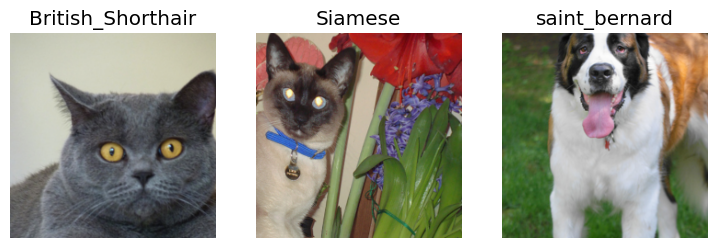

In [12]:
dls.show_batch(nrows=1, ncols=3)